# Proyecto2025_Riesgo_Operativo_Aerogeneradores_RioGrande_TDF

**Carrera:** Técnico en Ciencia de Datos e Inteligencia Artificial  
**Materia:** Aprendizaje Automático  
**Autor:** Sabrina Villegas  
**Fecha:** Junio 2025  
**Notebook:** Proyecto Final - Modelo Unificado

---

Este notebook contiene todas las etapas del proyecto: desde la carga y preprocesamiento de los datos hasta el entrenamiento del modelo predictivo y análisis de resultados.

El objetivo general es desarrollar un modelo de clasificación multiclase capaz de predecir el nivel de riesgo operativo (bajo, medio o alto) de los aerogeneradores del Parque Eólico Río Cullen, en Tierra del Fuego, Argentina, utilizando datos operativos y meteorológicos.

Las acciones principales incluyen:

- Limpieza y unificación de datasets operativos y meteorológicos.
- Análisis exploratorio de variables relevantes.
- Creación de características y variable objetivo.
- Entrenamiento y evaluación de modelos supervisados.
- Interpretación de métricas y recomendaciones finales.

---

In [11]:
# Importar librerías
import pandas as pd
import numpy as np

# Cargar datasets
path_operativo = '../data/raw/T1.csv'
path_meteorologico = '../data/raw/export.csv'

Se importan las librerías esenciales para procesamiento de datos y se definen las rutas hacia los archivos originales: el dataset operativo de SCADA y el meteorológico

In [14]:
# Carga con ajuste de separador y encoding para meteorológico
df_operativo = pd.read_csv(path_operativo)
df_meteorologico = pd.read_csv(path_meteorologico)

Se leen los datos desde archivos .csv y se convierten en DataFrame para su análisis posterior. Se espera que uno tenga registros cada 10 minutos (SCADA) y el otro datos diarios.

In [17]:
# Visualizar las primeras filas
print("Dataset Operativo (SCADA):")
display(df_operativo.head())

print("Dataset Meteorológico:")
display(df_meteorologico.head())

Dataset Operativo (SCADA):


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


Dataset Meteorológico:


,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2018-01-01 00:00:00,9.1,3.0,15.0,NaN,NaN,214.0,20.8,NaN,NaN,NaN
1,2018-01-02 00:00:00,7.3,5.0,10.0,NaN,NaN,146.0,15.2,NaN,NaN,NaN
2,2018-01-03 00:00:00,6.4,4.0,7.0,NaN,NaN,31.0,25.8,NaN,NaN,NaN
3,2018-01-04 00:00:00,8.7,6.0,12.0,NaN,NaN,351.0,19.5,NaN,NaN,NaN
4,2018-01-05 00:00:00,9.1,6.0,12.0,NaN,NaN,232.0,13.7,NaN,995.8,NaN


Este paso permite verificar la estructura, columnas, y posibles errores de lectura. Es fundamental para entender qué tipo de transformaciones serán necesarias.

In [20]:
# Información de datasets
print("Información Dataset Operativo:")
df_operativo.info()

Información Dataset Operativo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [22]:
print("Información Dataset Meteorológico:")
df_meteorologico.info()

Información Dataset Meteorológico:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    352 non-null    object 
 1   tavg    352 non-null    float64
 2   tmin    332 non-null    float64
 3   tmax    326 non-null    float64
 4   prcp    120 non-null    float64
 5   snow    6 non-null      float64
 6   wdir    319 non-null    float64
 7   wspd    324 non-null    float64
 8   wpgt    0 non-null      float64
 9   pres    78 non-null     float64
 10  tsun    0 non-null      float64
dtypes: float64(10), object(1)
memory usage: 30.4+ KB


In [24]:
# Conversión de fechas
df_operativo['Date/Time'] = pd.to_datetime(df_operativo['Date/Time'], dayfirst=True)
df_meteorologico['date'] = pd.to_datetime(df_meteorologico['date'])

Se convierten las columnas de fecha al tipo datetime para facilitar operaciones como el merge o filtrado temporal. Es esencial para alinear ambos datasets.

In [27]:
# Chequeo de duplicados, si existen se eliminan 
print(f"Duplicados en Operativo: {df_operativo.duplicated().sum()}")
print(f"Duplicados en Meteorológico: {df_meteorologico.duplicated().sum()}")


Duplicados en Operativo: 0
Duplicados en Meteorológico: 0


Eliminamos registros repetidos que podrían sesgar el análisis o el entrenamiento del modelo. Esto asegura consistencia y limpieza en los datos.

In [30]:
# LIMPIEZA inteligente de valores nulos
# Eliminar columnas con más del 40% de valores nulos
threshold = 0.4
df_operativo = df_operativo.dropna(axis=1, thresh=int((1-threshold) * len(df_operativo)))
df_meteorologico = df_meteorologico.dropna(axis=1, thresh=int((1-threshold) * len(df_meteorologico)))

In [32]:
# Eliminar filas con nulos remanentes
df_operativo = df_operativo.dropna()
df_meteorologico = df_meteorologico.dropna()

Primero se eliminan las filas con demasiados valores nulos y luego las restantes con faltantes aislados. Esto mejora la calidad de datos para evitar errores en el modelado.

In [35]:
# Merge de datasets por fecha
df_operativo_daily = df_operativo.resample('D', on='Date/Time').mean().reset_index()

In [37]:
df_merged = pd.merge(df_operativo_daily, df_meteorologico, left_on='Date/Time', right_on='date')

In [39]:
# Verificar el dataset unificado
print("Dataset Unificado:")
display(df_merged.head())

Dataset Unificado:


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),date,tavg,tmin,tmax,wdir,wspd
0,2018-01-01,1535.204483,8.022975,1622.990048,229.735242,2018-01-01,9.1,3.0,15.0,214.0,20.8
1,2018-01-02,3182.564250,12.000548,3314.693471,197.859789,2018-01-02,7.3,5.0,10.0,146.0,15.2
2,2018-01-03,1017.793340,6.650189,1072.956361,192.476045,2018-01-03,6.4,4.0,7.0,31.0,25.8
3,2018-01-04,834.486869,6.232531,838.463088,121.299142,2018-01-04,8.7,6.0,12.0,351.0,19.5
4,2018-01-05,123.717345,3.121434,130.342291,154.906666,2018-01-05,9.1,6.0,12.0,232.0,13.7


Se combinan los datasets operativos y climáticos en un solo DataFrame a través de la columna fecha_dia, lo cual permite cruzar información técnica y meteorológica para cada día.

FASE DE ANALISIS EXPLORATORIO

In [43]:
# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [44]:
# Configuración de estilo
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)


In [45]:
# 2. Cargar el dataset procesado
path_merged = '../data/processed/merged_dataset.csv'
df = pd.read_csv(path_merged)

In [46]:
# 3. Información básica del dataset
print("Información del Dataset:")
df.info()

Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      319 non-null    object 
 1   LV ActivePower (kW)            310 non-null    float64
 2   Wind Speed (m/s)               310 non-null    float64
 3   Theoretical_Power_Curve (KWh)  310 non-null    float64
 4   Wind Direction (°)             310 non-null    float64
 5   date                           319 non-null    object 
 6   tavg                           319 non-null    float64
 7   tmin                           319 non-null    float64
 8   tmax                           319 non-null    float64
 9   wdir                           319 non-null    float64
 10  wspd                           319 non-null    float64
dtypes: float64(9), object(2)
memory usage: 27.5+ KB


In [47]:
print("\nDescripción Estadística:")
display(df.describe())


Descripción Estadística:


,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),tavg,tmin,tmax,wdir,wspd
count,310.000000,310.000000,310.000000,310.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,1317.287886,7.585510,1507.519273,120.640516,5.550157,0.945455,10.809718,263.294671,24.587147
std,1054.933949,3.468848,1099.171409,72.446416,4.859820,4.856226,5.293903,67.345544,10.145746
min,0.000000,1.718272,0.996494,20.237690,-7.800000,-12.500000,-1.000000,0.000000,6.600000
25%,376.856659,4.982793,505.519086,55.995968,2.250000,-2.250000,7.000000,249.500000,15.500000
50%,1120.882746,7.272117,1367.158957,97.398282,5.200000,1.000000,10.700000,280.000000,24.200000
75%,2039.523871,9.721220,2327.303169,194.434329,9.150000,4.550000,15.000000,302.000000,32.450000
max,3602.284059,19.296762,3600.000000,294.238755,17.300000,13.000000,25.000000,357.000000,52.500000



Distribución de variables numéricas:


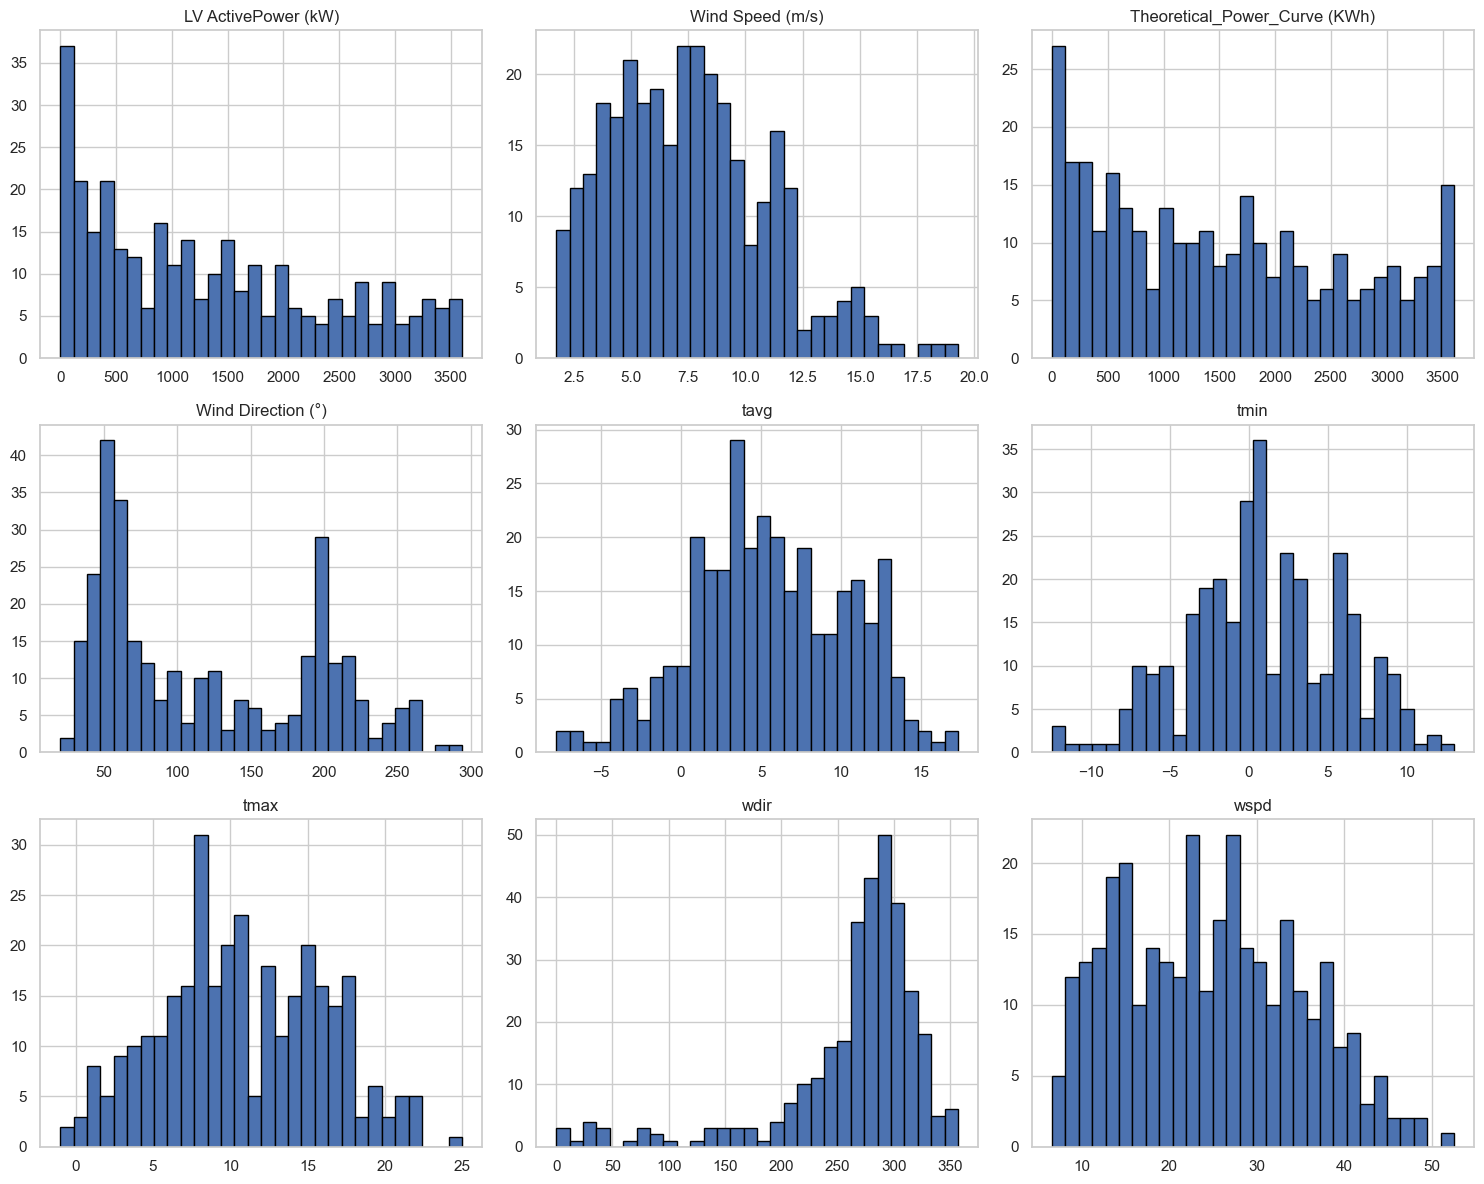

In [48]:
# 4. Distribución de variables numéricas
print("\nDistribución de variables numéricas:")
df.hist(figsize=(15, 12), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()


Boxplots para las principales variables:


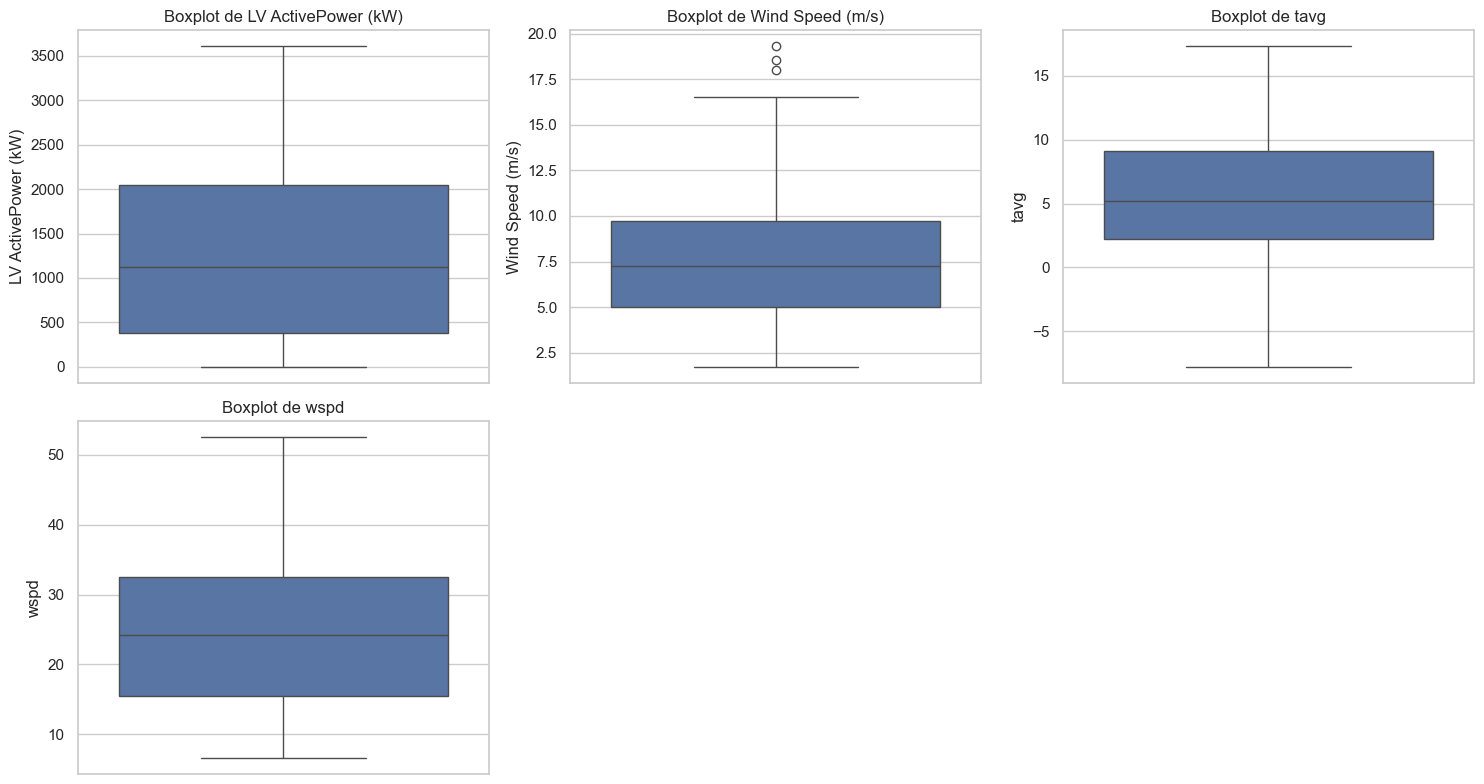

In [51]:
# 5. Boxplots para detección de outliers
print("\nBoxplots para las principales variables:")
variables_principales = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'tavg', 'wspd']
plt.figure(figsize=(15, 8))
for i, var in enumerate(variables_principales, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[var])
    plt.title(f'Boxplot de {var}')
plt.tight_layout()
plt.show()

FASE DE CARACTERISTICAS

In [56]:
# Importar librerías
import pandas as pd
import numpy as np


In [57]:
# Cargar el dataset procesado
path_merged = '../data/processed/merged_dataset.csv'
df = pd.read_csv(path_merged)

In [58]:
# Crear un índice de riesgo compuesto - Fórmula: combinación ponderada de variables climáticas

# Definir riesgo_score
# 0.6 * Velocidad del viento + 0.2 * Ráfagas de viento - 0.1 * Temperatura mínima
# Ajuste: normalizamos wspd de km/h a m/s dividiendo por 3.6 si queremos que las unidades sean coherentes 

df['wspd_m_s'] = df['wspd'] / 3.6  # opcional si querés unificar unidades

In [59]:
# Crear el riesgo_score
df['riesgo_score'] = (
    0.6 * df['Wind Speed (m/s)'] +
    0.2 * df['wspd_m_s'] - 
    0.1 * df['tmin']
)

In [60]:
# Crear la variable objetivo basada en riesgo_score
# Definimos los umbrales

def categorizar_riesgo_compuesto(score):
    if score < 10:
        return 'Bajo'
    elif 10 <= score < 20:
        return 'Medio'
    else:
        return 'Alto'

df['riesgo_operativo'] = df['riesgo_score'].apply(categorizar_riesgo_compuesto)

Se crea una nueva variable riesgo_operativo para clasificar el riesgo en 3 niveles a partir de un índice ponderado. Esta variable es el target para el modelo de clasificación.

In [62]:
# 5. Confirmar la distribución de clases

print("Distribución de clases en 'riesgo_operativo':")
print(df['riesgo_operativo'].value_counts())

Distribución de clases en 'riesgo_operativo':
riesgo_operativo
Bajo     297
Medio     13
Alto       9
Name: count, dtype: int64


In [64]:
# Crear variables adicionales - Binarizar si el viento es del oeste (270° +/- 45°)

def direccion_oeste(direccion):
    if (direccion >= 225) and (direccion <= 315):
        return 1
    else:
        return 0

df['viento_oeste'] = df['Wind Direction (°)'].apply(direccion_oeste)

FASE DE MODELO ENTRENADO Y EVALUACION

In [67]:
# Importar librerías
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [75]:
# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [76]:
# Métricas
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
# Cargar el dataset procesado
df = pd.read_csv('../data/processed/final_dataset.csv')

print("Primeras filas del dataset:")
display(df.head())

Primeras filas del dataset:


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),date,tavg,tmin,tmax,wdir,wspd,wspd_m_s,riesgo_score,riesgo_operativo,viento_oeste
0,2018-01-01,1535.204483,8.022975,1622.990048,229.735242,2018-01-01,9.1,3.0,15.0,214.0,20.8,5.777778,5.669340,Bajo,1
1,2018-01-02,3182.564250,12.000548,3314.693471,197.859789,2018-01-02,7.3,5.0,10.0,146.0,15.2,4.222222,7.544773,Bajo,0
2,2018-01-03,1017.793340,6.650189,1072.956361,192.476045,2018-01-03,6.4,4.0,7.0,31.0,25.8,7.166667,5.023447,Bajo,0
3,2018-01-04,834.486869,6.232531,838.463088,121.299142,2018-01-04,8.7,6.0,12.0,351.0,19.5,5.416667,4.222852,Bajo,0
4,2018-01-05,123.717345,3.121434,130.342291,154.906666,2018-01-05,9.1,6.0,12.0,232.0,13.7,3.805556,2.033971,Bajo,0


In [79]:
# 3. Preparar X (features) e y (target)
# Definir variables predictoras y Objetivo

X = df.drop(columns=['Date/Time', 'date', 'riesgo_operativo'])
X = X.select_dtypes(include=[np.number])  # Mantener solo variables numéricas
y = df['riesgo_operativo'] #Variable objetivo


Seleccionamos variables relevantes como características (X) y definimos la variable a predecir (y). Estas son las entradas y salidas que usará el modelo

In [85]:
# División 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [87]:
# 5. Imputar Valores Faltantes
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [89]:
# 5. Aplicar SMOTE solo en el train
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


Si una clase tiene menos como "alto riesgo", el modelo podría no aprender bien. SMOTE genera ejemplos sintéticos para balancear el dataset.

In [91]:
# 7. Estandarizar Datos (Para SVM y K-NN)
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

In [94]:
# 8. Entrenamiento de Modelos
modelos = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'K-NN': KNeighborsClassifier()
}

resultados = {}

for nombre, modelo in modelos.items():
    print(f"\nEntrenando modelo: {nombre}")
    
    if nombre in ['SVM', 'K-NN']:
        modelo.fit(X_train_bal_scaled, y_train_bal)
        y_pred = modelo.predict(X_test_scaled)
    else:
        modelo.fit(X_train_bal, y_train_bal)
        y_pred = modelo.predict(X_test)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    resultados[nombre] = classification_report(y_test, y_pred, output_dict=True)


Entrenando modelo: Decision Tree
[[ 0  2  0]
 [ 0 59  0]
 [ 0  1  2]]
              precision    recall  f1-score   support

        Alto       0.00      0.00      0.00         2
        Bajo       0.95      1.00      0.98        59
       Medio       1.00      0.67      0.80         3

    accuracy                           0.95        64
   macro avg       0.65      0.56      0.59        64
weighted avg       0.92      0.95      0.94        64


Entrenando modelo: Random Forest


C:\Users\sabri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sabri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sabri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sabri\anaconda3\Lib\site-packag

[[ 0  2  0]
 [ 0 59  0]
 [ 0  1  2]]
              precision    recall  f1-score   support

        Alto       0.00      0.00      0.00         2
        Bajo       0.95      1.00      0.98        59
       Medio       1.00      0.67      0.80         3

    accuracy                           0.95        64
   macro avg       0.65      0.56      0.59        64
weighted avg       0.92      0.95      0.94        64


Entrenando modelo: SVM
[[ 2  0  0]
 [ 4 55  0]
 [ 0  1  2]]
              precision    recall  f1-score   support

        Alto       0.33      1.00      0.50         2
        Bajo       0.98      0.93      0.96        59
       Medio       1.00      0.67      0.80         3

    accuracy                           0.92        64
   macro avg       0.77      0.87      0.75        64
weighted avg       0.96      0.92      0.93        64


Entrenando modelo: K-NN
[[ 2  0  0]
 [ 7 50  2]
 [ 0  0  3]]
              precision    recall  f1-score   support

        Alto       0.22

C:\Users\sabri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sabri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sabri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sabri\anaconda3\Lib\site-packag

Para el desarrollo del modelo, dividí los datos en 80% para entrenamiento y 20% para prueba.
Se separan los datos para entrenar el modelo con una parte y probarlo con otra, lo que permite evaluar su rendimiento real y evitar overfitting.
. Se elige Random Forest por su buena capacidad de clasificación y manejo de datos no lineales. Aprende patrones entre los datos de entrada y la variable de riesgo.
. Se evalúa el desempeño del modelo con métricas como precisión, recall y F1-score. La matriz de confusión muestra cómo se clasificaron los distintos niveles de riesgo.


In [97]:
# 9. Comparación de Modelos
summary = pd.DataFrame({
    modelo: {
        'Accuracy': resultados[modelo]['accuracy'],
        'Precision (Macro)': resultados[modelo]['macro avg']['precision'],
        'Recall (Macro)': resultados[modelo]['macro avg']['recall'],
        'F1-Score (Macro)': resultados[modelo]['macro avg']['f1-score']
    }
    for modelo in resultados
}).T

print("Resumen Comparativo de Modelos:")
display(summary)

Resumen Comparativo de Modelos:


,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro)
Decision Tree,0.953125,0.650538,0.555556,0.591736
Random Forest,0.953125,0.650538,0.555556,0.591736
SVM,0.921875,0.771825,0.866290,0.752174
K-NN,0.859375,0.607407,0.949153,0.677023


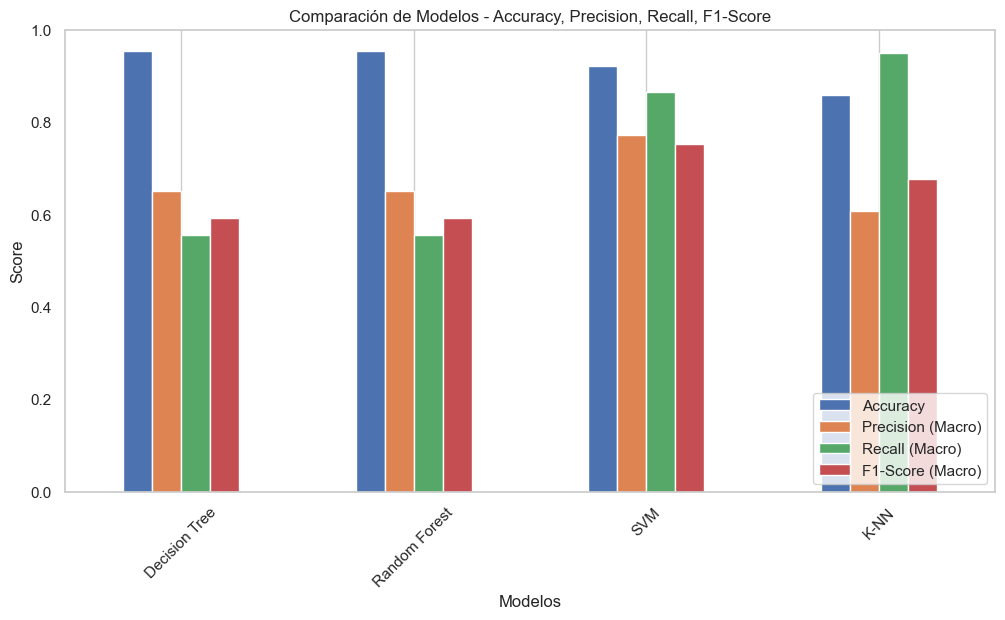

In [99]:
import matplotlib.pyplot as plt

# Graficar resultados
summary.plot(kind='bar', figsize=(12, 6))
plt.title('Comparación de Modelos - Accuracy, Precision, Recall, F1-Score')
plt.ylabel('Score')
plt.xlabel('Modelos')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.show()

In [101]:
# 1. Ordenar por F1-Score Macro
summary_sorted = summary.sort_values(by='F1-Score (Macro)', ascending=False)

# 2. Mostrar tabla ordenada
print("Resumen Comparativo de Modelos (Ordenado por F1-Score):")
display(summary_sorted)

# 3. Mostrar Mejor Modelo
mejor_modelo = summary_sorted.index[0]
print(f"🏆 El mejor modelo según F1-Score es: {mejor_modelo}")

Resumen Comparativo de Modelos (Ordenado por F1-Score):


,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro)
SVM,0.921875,0.771825,0.866290,0.752174
K-NN,0.859375,0.607407,0.949153,0.677023
Decision Tree,0.953125,0.650538,0.555556,0.591736
Random Forest,0.953125,0.650538,0.555556,0.591736


🏆 El mejor modelo según F1-Score es: SVM


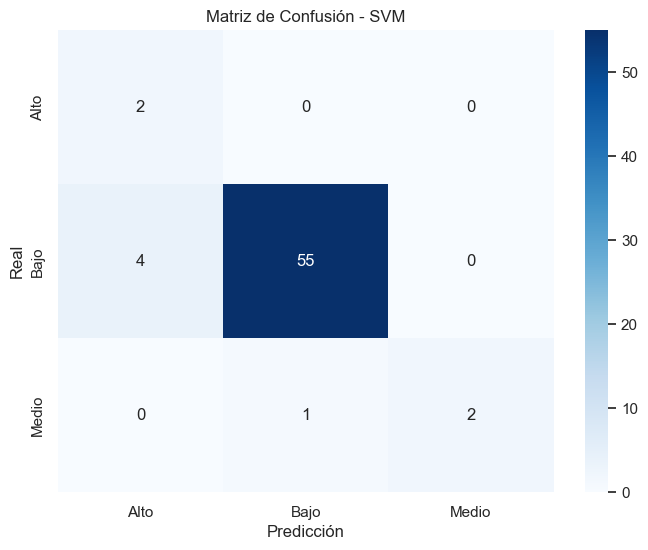

In [103]:
# Reentrenar mejor modelo si hace falta (opcional)
modelo_seleccionado = modelos[mejor_modelo]

if mejor_modelo in ['SVM', 'K-NN']:
    modelo_seleccionado.fit(X_train_bal_scaled, y_train_bal)
    y_pred_mejor = modelo_seleccionado.predict(X_test_scaled)
else:
    modelo_seleccionado.fit(X_train_bal, y_train_bal)
    y_pred_mejor = modelo_seleccionado.predict(X_test)

# 4. Generar matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred_mejor)

# 5. Graficar
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title(f'Matriz de Confusión - {mejor_modelo}')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

En conclusión, el modelo desarrollado cumple con los objetivos del proyecto ya que anticipa escenarios de riesgo operativo, permite mejorar la planificación del mantenimiento y aumenta la seguridad del parque eólico. Ademas, este proyecto demuestra el valor de aplicar Machine Learning a la industria energética.

Como recomendaciones futuras, sugiero:
- Incorporar más años de datos
- Ajustar los umbrales de riesgo con expertos del sector
- explorar modelos más complejos como redes neuronales o análisis en tiempo real

